### Bayesian Optimal Pricing

**"price optimization"** means optimizing the price of a good or service given costs and revenue.

Revenue is generally subject to the “demand curve,” which is simply a relation between price and units demanded by consumers. 

Low price will attract anyone in the market, without concerning much about bring down enough revenue; and high price would attract only few customers those who can afford; so its very important to keep price at an optimum level so that profitable revenue is generated 

The **Bayesian approach**, models the joint distribution over all parameters and helps to simulate how revenue, cost, and profits respond to changes in price.

#### Demand Curve

First, we need a demand curve; we’ll simulate our own for simplicity. There are multiple approaches to demand curve modeling. 

One that tends to work really well incorporates exponential decay. As the price approaches zero, the predicted demand would be infinitely high, whereas if the price were arbitrarily (infinitely) high, the demand would asymptotically approach zero.

In [2]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
plt.style.context('fivethirtyeight')

import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore")

In [3]:
sd = 0.5
m,b = -0.25, 5
X = np.linspace(0,20,100)
Y = np.exp(np.random.normal(loc=m*X+b, scale=sd))

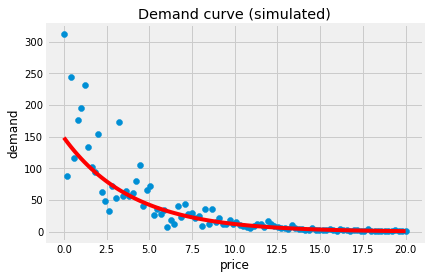

In [4]:
plt.scatter(X,Y)
Y_hat = np.exp(m*X+b)
plt.plot(X,Y_hat, color='r')
plt.title('Demand curve (simulated)')
plt.xlabel('price')
plt.ylabel('demand')
plt.show()

If we convert demand into log scale, a linear relationship exists between price and log units demanded.

Now lets convert our parameters into priors:

  > slope and intercept could be positive or negative, can be used normal priors. 
    
  > noise (error) can never be negative, can take as exponential distribution.

In [5]:
with pm.Model() as model:
    #priors
    m = pm.Normal('m',mu=0, sd=2)
    b = pm.Normal('b',mu=0, sd=2)
    s = pm.Exponential('s',lam=1)
    
    #Likelihood
    y_hat = pm.math.dot(m, X) + b
    likelihood = pm.Normal('y', mu=y_hat, observed=pm.math.log(Y), sigma=s)
    
    #posterior
    trace = pm.sample(1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, b, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 280 seconds.


**Observe the distribution of parameters**

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 504x504 with 0 Axes>

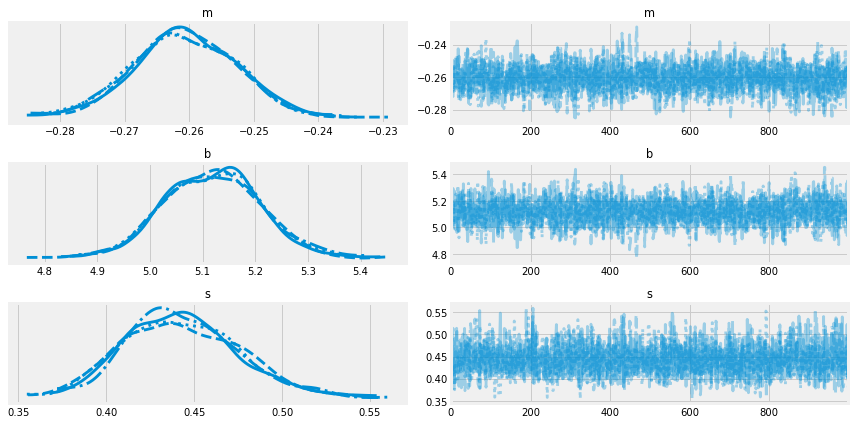

In [6]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()
plt.show()

#### Posterior predictive distribution

In [7]:
def post_plot(trace_obj=trace,samples=100,size=len(X)):
    for itr in range(samples):
        idx = random.choice(range(size))
        m = trace_obj.get_values('m')[idx]
        b = trace_obj.get_values('b')[idx]
        Y_hat = np.exp(m*X + b)
        plt.plot(X,Y_hat)
        plt.title('Posterior predictive distribution')
    
    plt.scatter(X,Y)
 

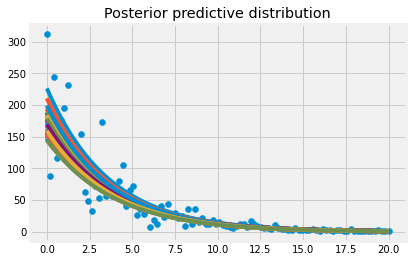

In [8]:
post_plot()

#### Optimization (profit maximization)

In [9]:
#define a cost function
def cost(X):
    return 1.5*X + 50

In [10]:
def prof_posterior(samples=100, size=len(X)):
    prices = []
    profits = []
    
    for s in range(samples):
        idx = random.choice(range(size))
        m = trace.get_values('m')[idx]
        b = trace.get_values('b')[idx]
        demand = np.exp(m*X +b)
        rev = X * demand
        prof = rev - cost(demand)
        plt.plot(X, prof)
        plt.xlabel('price')
        plt.ylabel('profit')
    
        best_price = X[np.argmax(prof)]
        best_prof = np.max(prof)
        prices.append(best_price)
        profits.append(best_prof)
        
    res = dict(zip(prices, profits))    
    plt.axvline(x=max(res, key=res.get), color='black', linewidth=1, linestyle = 'dashed')
    plt.text(5.5, -100, 'best price = {0:.2f}'.format(max(prices)),ha='left', fontsize=12)
    plt.title('profit optimization')
        
    return prices,profits   

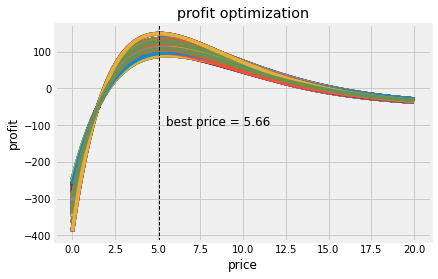

In [11]:
prices, profits = prof_posterior(samples=1000)

price 5.66 generates the maximum profit